In [23]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
base = Path.cwd().parents[1]
df = pd.read_csv(base / "Data_clean/caract-2005-2023.csv")

df.head()


C:\Users\jeanl\AppData\Local\Temp\ipykernel_9152\3316542733.py:8: DtypeWarning: Columns (10,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(base / "Data_clean/caract-2005-2023.csv")


,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep,Accident_Id,date,weekday
0,2.005000e+11,2005,1,12,19:00,3,2,1,1.0,3.0,11,CD41B,M,50.515,2.944,590,NaN,2005-01-12,3
1,2.005000e+11,2005,1,21,16:00,1,2,1,1.0,1.0,51,rue de Lille,M,50.537,2.802,590,NaN,2005-01-21,5
2,2.005000e+11,2005,1,21,18:45,3,1,1,2.0,1.0,51,NaN,M,50.546,2.800,590,NaN,2005-01-21,5
3,2.005000e+11,2005,1,4,16:15,1,1,1,1.0,5.0,82,NaN,M,50.987,2.408,590,NaN,2005-01-04,2
4,2.005000e+11,2005,1,10,19:45,3,1,1,3.0,6.0,478,NaN,M,50.964,2.475,590,NaN,2005-01-10,1


In [24]:
df_night = df[(df["hrmn"] > "23:00") | (df["hrmn"] < "06:00")]

In [25]:

df_night = df_night.copy()  
df_night["night"] = df_night["weekday"]

mask_early_morning = df_night["hrmn"] < "06:00"


df_night.loc[mask_early_morning & (df_night["weekday"] != 1), "night"] = df_night["weekday"] - 1
df_night.loc[mask_early_morning & (df_night["weekday"] == 1), "night"] = 7
df_night = df_night.drop_duplicates(subset=['Num_Acc'], keep='first')

print("Exemples d'ajustement pour les heures < 06:00:")
early_morning = df_night[df_night["hrmn"] < "06:00"][["hrmn", "weekday", "night"]].head(10)
print(early_morning)

print(f"\nDistribution des accidents de nuit par jour:")
print(df_night["night"].value_counts().sort_index())

Exemples d'ajustement pour les heures < 06:00:
      hrmn  weekday  night
10   02:30        7      6
27   00:45        7      6
36   00:15        6      5
41   05:00        4      3
69   00:30        6      5
76   03:00        4      3
81   05:00        6      5
84   05:30        7      6
105  02:30        7      6
114  05:30        7      6

Distribution des accidents de nuit par jour:
night
1     9250
2    10473
3    11640
4    14623
5    26895
6    29679
7    10264
Name: count, dtype: int64


In [26]:
df_night.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112824 entries, 10 to 1231683
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      112823 non-null  float64
 1   an           112824 non-null  int64  
 2   mois         112824 non-null  int64  
 3   jour         112824 non-null  int64  
 4   hrmn         112824 non-null  object 
 5   lum          112824 non-null  int64  
 6   agg          112824 non-null  int64  
 7   int          112824 non-null  int64  
 8   atm          112818 non-null  float64
 9   col          112821 non-null  float64
 10  com          112823 non-null  object 
 11  adr          95841 non-null   object 
 12  gps          48288 non-null   object 
 13  lat          69095 non-null   float64
 14  long         68793 non-null   float64
 15  dep          112824 non-null  object 
 16  Accident_Id  1 non-null       float64
 17  date         112824 non-null  object 
 18  weekday      112824 non-nul

In [27]:
df_night.Num_Acc.nunique()

112823

## Nombre d'accident chaque soir


       nb_accidents
night              
1              9250
2             10473
3             11640
4             14622
5             26895
6             29679
7             10264


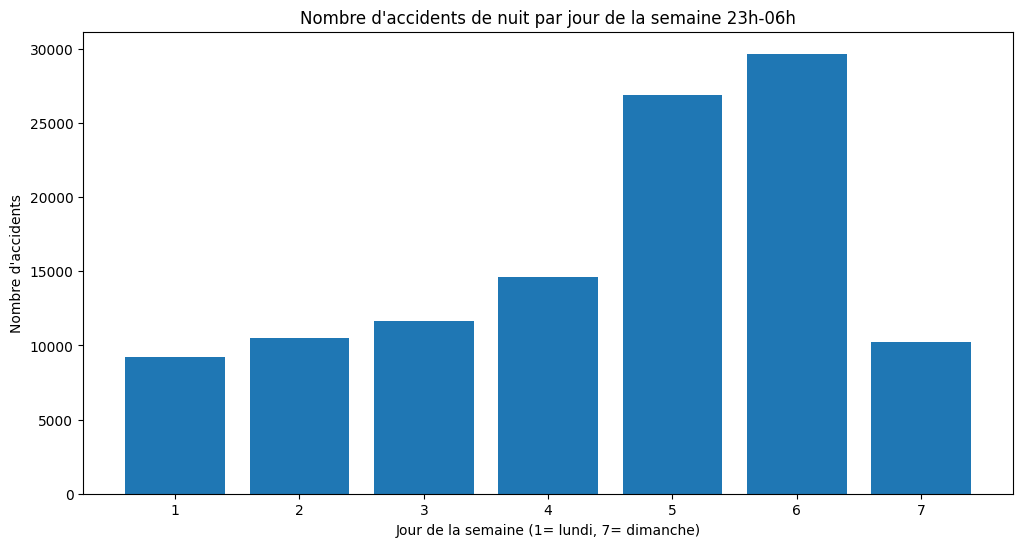

In [28]:
nb_accidents = df_night.groupby("night").Num_Acc.nunique().to_frame(name = "nb_accidents")
print(nb_accidents)
plt.figure(figsize = (12,6))
plt.bar(nb_accidents.index, nb_accidents["nb_accidents"])
plt.xlabel("Jour de la semaine (1= lundi, 7= dimanche)")
plt.ylabel("Nombre d'accidents")
plt.title("Nombre d'accidents de nuit par jour de la semaine 23h-06h")
plt.show()

## Fusion des datasets

In [29]:
base = Path.cwd().parents[1]
df_lieux = pd.read_csv(base / "Data_clean/lieux-2005-2023.csv")
df_vehicules = pd.read_csv(base / "Data_clean/vehicules-2005-2023.csv", index_col=0)
df_usagers = pd.read_csv(base / "Data_clean/usagers-2005-2023.csv",index_col=0)
df_night["Num_Acc"] = df_night["Num_Acc"].fillna(0).astype(int)
df_lieux.head()


C:\Users\jeanl\AppData\Local\Temp\ipykernel_9152\1966255536.py:2: DtypeWarning: Columns (2,6,7,8,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lieux = pd.read_csv(base / "Data_clean/lieux-2005-2023.csv")
C:\Users\jeanl\AppData\Local\Temp\ipykernel_9152\1966255536.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vehicules = pd.read_csv(base / "Data_clean/vehicules-2005-2023.csv", index_col=0)
C:\Users\jeanl\AppData\Local\Temp\ipykernel_9152\1966255536.py:4: DtypeWarning: Columns (9,13,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_usagers = pd.read_csv(base / "Data_clean/usagers-2005-2023.csv",index_col=0)


,Num_Acc,catr,voie,v1,v2,circ,nbv,pr,pr1,vosp,prof,plan,lartpc,larrout,surf,infra,situ,env1,vma
0,200500000001,3.0,41.0,0.0,B,2.0,2,1.0,430.0,0.0,1.0,1.0,0,63,1.0,0.0,1.0,0.0,NaN
1,200500000002,2.0,41.0,0.0,NaN,0.0,2,0.0,0.0,1.0,1.0,1.0,0,100,1.0,0.0,5.0,0.0,NaN
2,200500000003,2.0,41.0,0.0,NaN,0.0,0,0.0,0.0,1.0,1.0,1.0,0,0,2.0,0.0,5.0,0.0,NaN
3,200500000004,3.0,916.0,0.0,NaN,2.0,2,0.0,0.0,0.0,1.0,1.0,0,0,1.0,0.0,1.0,0.0,NaN
4,200500000005,3.0,110.0,0.0,NaN,2.0,2,24.0,630.0,0.0,1.0,3.0,0,59,2.0,0.0,3.0,0.0,NaN


In [30]:
df_complet = df_night.merge(df_lieux, on="Num_Acc", how="inner")
df_complet = df_complet.drop_duplicates(subset=['Num_Acc'], keep='first')

In [31]:
df_complet = df_complet.merge(df_vehicules, on="Num_Acc", how = "inner")


In [32]:
pd.set_option('display.max_columns', None)  
df_complet

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep,Accident_Id,date,weekday,night,catr,voie,v1,v2,circ,nbv,pr,pr1,vosp,prof,plan,lartpc,larrout,surf,infra,situ,env1,vma,senc,catv,occutc,obs,obsm,choc,manv,num_veh,id_vehicule,motor
0,200500000011,2005,1,23,02:30,3,1,1,1.0,3.0,401,NaN,M,0.000000,0.000000,590,NaN,2005-01-23,7,6,2.0,42.0,0.0,NaN,2.0,2,1.0,860.0,0.0,1.0,1.0,0,75,0.0,0.0,1.0,0.0,NaN,0.0,7,0.0,0.0,2.0,2.0,17.0,A01,NaN,NaN
1,200500000011,2005,1,23,02:30,3,1,1,1.0,3.0,401,NaN,M,0.000000,0.000000,590,NaN,2005-01-23,7,6,2.0,42.0,0.0,NaN,2.0,2,1.0,860.0,0.0,1.0,1.0,0,75,0.0,0.0,1.0,0.0,NaN,0.0,7,0.0,0.0,0.0,8.0,1.0,B02,NaN,NaN
2,200500000028,2005,1,2,00:45,3,1,9,2.0,1.0,298,NaN,M,50.238000,3.174000,620,NaN,2005-01-02,7,6,2.0,43.0,0.0,NaN,2.0,2,0.0,0.0,3.0,0.0,1.0,0,68,2.0,5.0,1.0,0.0,NaN,0.0,7,0.0,0.0,2.0,1.0,15.0,A01,NaN,NaN
3,200500000028,2005,1,2,00:45,3,1,9,2.0,1.0,298,NaN,M,50.238000,3.174000,620,NaN,2005-01-02,7,6,2.0,43.0,0.0,NaN,2.0,2,0.0,0.0,3.0,0.0,1.0,0,68,2.0,5.0,1.0,0.0,NaN,0.0,7,0.0,0.0,2.0,4.0,0.0,B02,NaN,NaN
4,200500000037,2005,1,29,00:15,3,1,1,1.0,1.0,43,NaN,M,50.907000,1.954000,620,NaN,2005-01-29,6,5,2.0,43.0,0.0,NaN,2.0,0,0.0,0.0,0.0,1.0,1.0,0,76,1.0,0.0,1.0,0.0,NaN,0.0,7,0.0,0.0,0.0,2.0,2.0,A01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166886,202300054795,2023,5,7,05:00,5,2,3,3.0,3.0,75111,BOULEVARD VOLTAIRE,NaN,48.852152,2.389584,75,NaN,2023-05-07,7,6,4.0,BOULEVARD VOLTAIRE,0.0,NaN,2.0,0,-1,-1,0.0,1.0,1.0,NaN,-1,2.0,0.0,1.0,NaN,30.0,1.0,7,NaN,1.0,0.0,2.0,1.0,B01,155 583 393,0.0
166887,202300054802,2023,10,27,05:20,3,1,1,2.0,7.0,91174,RN 104,NaN,48.622196,2.463582,91,NaN,2023-10-27,5,4,2.0,RN 104,0.0,NaN,3.0,6,33,900,0.0,2.0,1.0,NaN,-1,2.0,0.0,1.0,NaN,90.0,2.0,15,NaN,4.0,0.0,3.0,2.0,A01,155 583 377,1.0
166888,202300054807,2023,10,27,05:50,3,1,1,1.0,6.0,92036,A86,NaN,48.934292,2.270874,92,NaN,2023-10-27,5,4,1.0,A86,0.0,NaN,3.0,2,6,849,0.0,1.0,1.0,NaN,-1,2.0,0.0,1.0,NaN,90.0,2.0,7,NaN,4.0,0.0,1.0,1.0,A01,155 583 368,1.0
166889,202300054808,2023,10,26,03:50,3,1,9,2.0,6.0,92025,A86,NaN,48.919885,2.224617,92,NaN,2023-10-26,4,3,1.0,A86,0.0,NaN,1.0,2,2,599,0.0,2.0,3.0,NaN,7,2.0,3.0,3.0,NaN,30.0,1.0,7,NaN,4.0,0.0,1.0,12.0,A01,155 583 367,1.0


## Nombre de vehicules Impliqué dans un accident

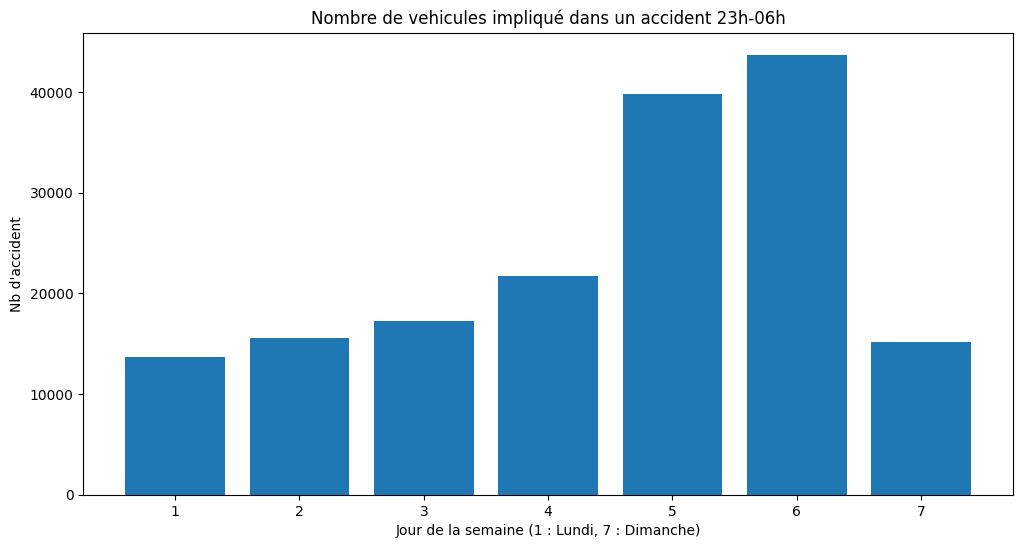

In [33]:
nb_vehicules = df_complet.groupby("night").size()
plt.figure(figsize=(12, 6))
plt.bar(nb_vehicules.index, nb_vehicules)
plt.title('Nombre de vehicules impliqué dans un accident 23h-06h')
plt.xlabel("Jour de la semaine (1 : Lundi, 7 : Dimanche)")
plt.ylabel("Nb d'accident")
plt.show()


## Nombre moyen de véhicules impliqué par accident

night
1    1.475459
2    1.487635
3    1.486512
4    1.483108
5    1.478528
6    1.472657
7    1.481099
dtype: float64


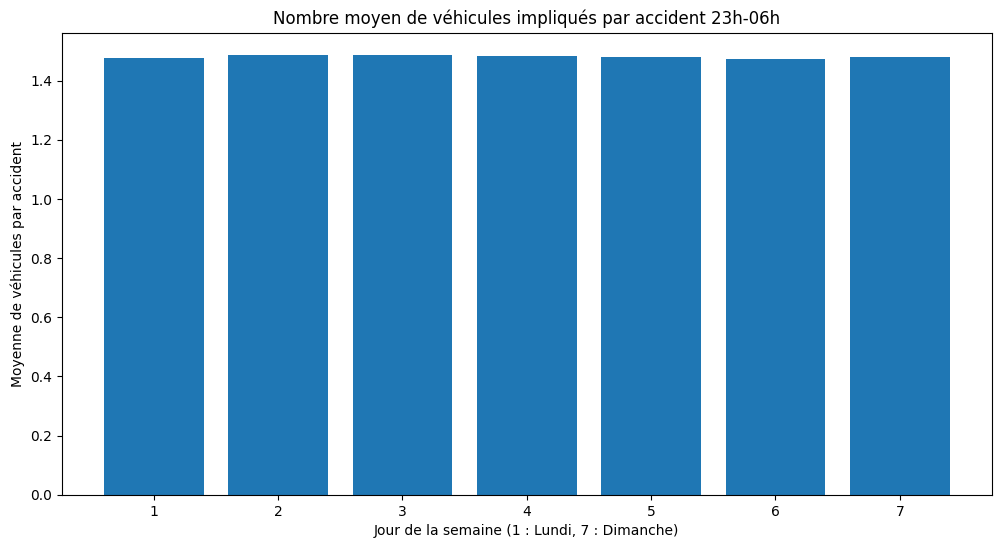

In [34]:
nb_vehicules = nb_vehicules.to_frame(name="nb_vehicules")
vehicules_par_accident = nb_vehicules["nb_vehicules"] / nb_accidents["nb_accidents"]
print(vehicules_par_accident)
plt.figure(figsize=(12, 6))
plt.bar(vehicules_par_accident.index, vehicules_par_accident)
plt.title("Nombre moyen de véhicules impliqués par accident 23h-06h")
plt.xlabel("Jour de la semaine (1 : Lundi, 7 : Dimanche)")  
plt.ylabel("Moyenne de véhicules par accident")
plt.show()

In [35]:
df_complet = df_complet.merge(df_usagers, on="Num_Acc", how = "inner")

In [36]:
df_complet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410717 entries, 0 to 410716
Data columns (total 64 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Num_Acc        410717 non-null  int64  
 1   an             410717 non-null  int64  
 2   mois           410717 non-null  int64  
 3   jour           410717 non-null  int64  
 4   hrmn           410717 non-null  object 
 5   lum            410717 non-null  int64  
 6   agg            410717 non-null  int64  
 7   int            410717 non-null  int64  
 8   atm            410705 non-null  float64
 9   col            410683 non-null  float64
 10  com            410705 non-null  object 
 11  adr            348367 non-null  object 
 12  gps            173350 non-null  object 
 13  lat            249603 non-null  float64
 14  long           248698 non-null  float64
 15  dep            410717 non-null  object 
 16  Accident_Id    0 non-null       float64
 17  date           410717 non-nul

## Nombre de personne impliqué dans un accident 


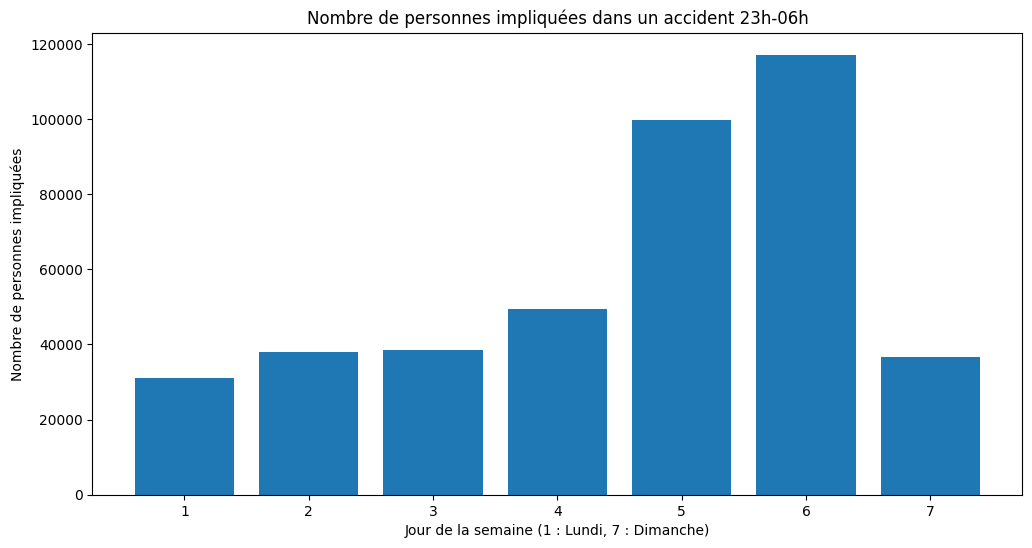

In [37]:
nb_personnes = df_complet.groupby("night").size().to_frame(name="nb_personnes")
plt.figure(figsize=(12, 6))
plt.bar(nb_personnes.index, nb_personnes["nb_personnes"])
plt.title("Nombre de personnes impliquées dans un accident 23h-06h")
plt.xlabel("Jour de la semaine (1 : Lundi, 7 : Dimanche)")
plt.ylabel("Nombre de personnes impliquées")
plt.show()

## Nombre moyen de personne impliqué par accident 

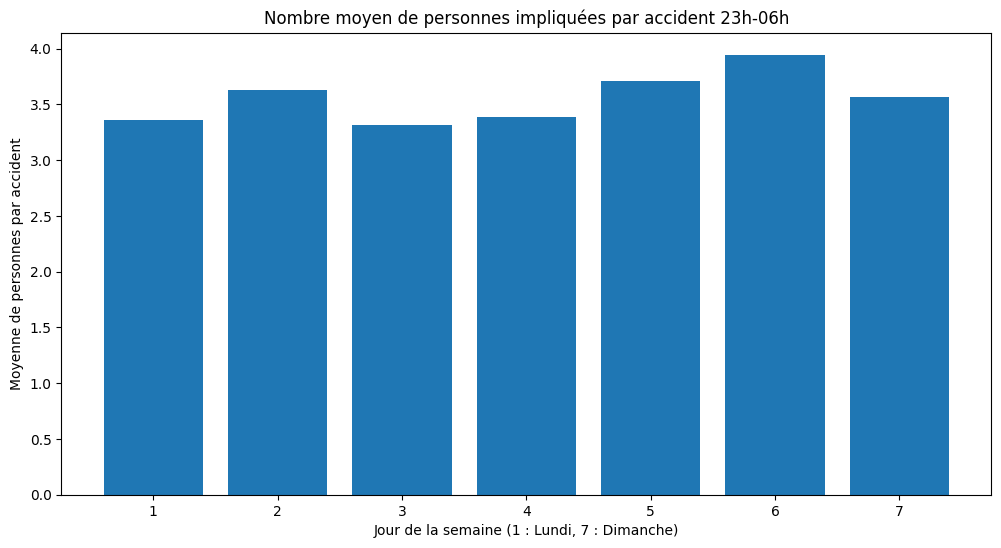

In [38]:
personnes_par_accident = nb_personnes["nb_personnes"] / nb_accidents["nb_accidents"]
plt.figure(figsize=(12, 6))
plt.bar(personnes_par_accident.index, personnes_par_accident)
plt.title("Nombre moyen de personnes impliquées par accident 23h-06h")
plt.xlabel("Jour de la semaine (1 : Lundi, 7 : Dimanche)")
plt.ylabel("Moyenne de personnes par accident")
plt.show()